In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,regularizers,optimizers
from scipy.io import loadmat,savemat

In [2]:
import time

In [7]:

#####Reaaranging acquired data in the desired format(converting all (100, 100) matrix into (1, 10000)rows and then
#####removing the gaussian profile (Bg) to get only the perturbation saved in file "diff_image" and "diff_phasescreen" #####

start_time = time.time()
for a in range(0,9):
    A = np.loadtxt('phasescrn_'+str(a)+'.DAT',dtype = 'float')
    B = np.loadtxt('image_'+str(a)+'.DAT',dtype ='float')
    #Ag = A[0:100,:]
    m = np.zeros((5000, 10000))
    n = np.zeros((5000, 10000))
    #### First image is a gaussian with no perturbation
    Bg = B[0:100,:] # first image
    Ai = A[100:500100,:] # all other samples
    Bi = B[100:500100,:]
    for i in range(5000):
        Bi[i*100:(i+1)*100,:] = Bi[i*100:(i+1)*100,:]-Bg

    for i in range (5000):
        l = 0
        for j in range (i*100, (i+1)*100):
            for k in range(100):

                n[i][l] = Ai[j][k]
                m[i][l] = Bi[j][k]
                l = l+1
    file1 = open('diff_phasescreen_'+str(a)+'.DAT', 'w')
    file2 = open('diff_image_'+str(a)+'.DAT', 'w')
    np.savetxt(file1, n)
    np.savetxt(file2, m)
    file1.close()
    file2.close()
print("--- %s seconds ---" % (time.time() - start_time))


--- 672.706137418747 seconds ---


In [5]:
g = np.loadtxt('diff_image_'+str(0)+'.DAT',dtype = float)
f = np.loadtxt('diff_phasescreen_'+str(0)+'.DAT',dtype = float)
print(np.shape(g))
for i in range(1,9):
    m = np.loadtxt('diff_image_'+str(i)+'.DAT',dtype = float)
    n = np.loadtxt('diff_phasescreen_'+str(i)+'.DAT',dtype = float)
    g = np.concatenate((g, m))
    f = np.concatenate((f, n))
    print(np.shape(g))

(5000, 10000)


In [25]:
print(np.shape(Bg))
print(np.shape(B))

(100, 100)
(500100, 100)


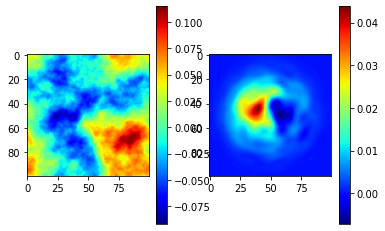

In [10]:
##Some random phasescreen
plt.subplot(1,2,1)
plt.imshow(A[342000:342100,:],cmap = 'jet')
plt.colorbar()

##Its corresponding perturbation
plt.subplot(1,2,2)
plt.imshow(Bi[342000:342100,:], cmap = 'jet')
plt.colorbar()


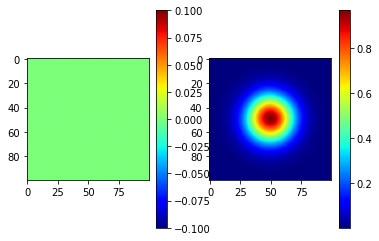

In [119]:
### Phasescreen with all values zero
plt.subplot(1,2,1)
plt.imshow(A[0:100,:],cmap = 'jet')
plt.colorbar()

### Gaussian beam with no perturbation 
plt.subplot(1,2,2)
plt.imshow(Bi[0:100,:], cmap = 'jet')
plt.colorbar()

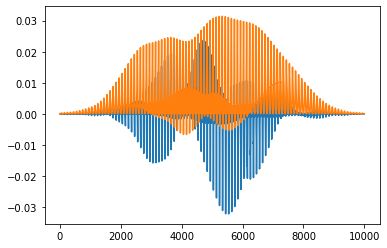

In [9]:
plt.plot(m[0,:])
plt.plot(g[25000,:])

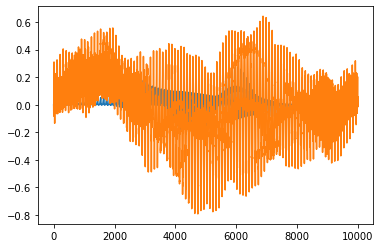

In [15]:
plt.plot(g[40001,:])
plt.plot(f[40001,:])

In [7]:
#### Assign 1000 for test data and 44000 for training
l=int(np.shape(g)[0]- 1000);
train_x=g[0:l,:]
train_z=f[0:l,:]
test_x=g[l:len(g[:,1]),:]
test_z=f[l:len(f[:,1]),:]

In [ ]:
import gc
#del Ai 
#gc.collect()
del g 
gc.collect()
del f
gc.collect()
del m
gc.collect()
del n
#del Bi 
gc.collect()

In [12]:

print(np.shape(test_x))

(1000, 10000)


In [33]:
test_x[0].shape

(10000,)

In [13]:
### The neural network ###

inputs1=keras.Input(shape=test_x[0].shape)

flat1=layers.Dense(1000,activation='linear')(inputs1)
hidden1=layers.Dense(500,activation='relu')(flat1)
drop1=layers.Dropout(0.1)(hidden1)
hidden2=layers.Dense(500,activation='relu')(drop1)
drop2=layers.Dropout(0.1)(hidden2)
hidden3=layers.Dense(500,activation='relu')(drop2)
#drop3=layers.Dropout(0.1)(hidden3)
#hidden4=layers.Dense(500,activation='relu')(drop3)
#outputs1=layers.Dense(len(train_z[0,:]),activation='linear')(hidden4)
outputs1=layers.Dense(len(train_z[0,:]),activation='linear')(hidden3)
model=keras.Model(inputs=inputs1,outputs=outputs1)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 1000)              10001000  
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500

In [14]:
### Training the model ###
from tensorflow.keras import metrics, regularizers, optimizers
model.compile(optimizer=optimizers.Adam(learning_rate = 0.0005),loss=tf.keras.losses.Huber(delta = 0.01),metrics=['accuracy'])
history=model.fit(train_x,train_z,batch_size=128,validation_split=0.2,epochs=500)

Epoch 1/500
275/275 [==============================] - 58s 206ms/step - loss: 0.0011 - accuracy: 2.8409e-05 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2/500
275/275 [==============================] - 53s 193ms/step - loss: 0.0011 - accuracy: 1.7045e-04 - val_loss: 0.0010 - val_accuracy: 2.2727e-04
Epoch 3/500
275/275 [==============================] - 53s 192ms/step - loss: 0.0010 - accuracy: 4.2614e-04 - val_loss: 9.7194e-04 - val_accuracy: 2.2727e-04
Epoch 4/500
275/275 [==============================] - 54s 195ms/step - loss: 9.5945e-04 - accuracy: 6.5341e-04 - val_loss: 9.2801e-04 - val_accuracy: 9.0909e-04
Epoch 5/500
275/275 [==============================] - 54s 197ms/step - loss: 9.3200e-04 - accuracy: 6.8182e-04 - val_loss: 9.0649e-04 - val_accuracy: 0.0015
Epoch 6/500
275/275 [==============================] - 55s 199ms/step - loss: 9.0564e-04 - accuracy: 9.3750e-04 - val_loss: 8.8124e-04 - val_accuracy: 0.0010
Epoch 7/500
275/275 [==============================] - 5

Epoch 106/500
275/275 [==============================] - 34s 124ms/step - loss: 4.1654e-04 - accuracy: 0.0074 - val_loss: 4.1850e-04 - val_accuracy: 0.0064
Epoch 107/500
275/275 [==============================] - 34s 124ms/step - loss: 4.1546e-04 - accuracy: 0.0081 - val_loss: 4.1161e-04 - val_accuracy: 0.0073
Epoch 108/500
275/275 [==============================] - 34s 125ms/step - loss: 4.1600e-04 - accuracy: 0.0078 - val_loss: 4.1427e-04 - val_accuracy: 0.0085
Epoch 109/500
275/275 [==============================] - 36s 131ms/step - loss: 4.1532e-04 - accuracy: 0.0084 - val_loss: 4.1588e-04 - val_accuracy: 0.0070
Epoch 110/500
275/275 [==============================] - 35s 128ms/step - loss: 4.1398e-04 - accuracy: 0.0085 - val_loss: 4.1193e-04 - val_accuracy: 0.0080
Epoch 111/500
275/275 [==============================] - 38s 137ms/step - loss: 4.1357e-04 - accuracy: 0.0076 - val_loss: 4.1109e-04 - val_accuracy: 0.0090
Epoch 112/500
275/275 [==============================] - 36s 131

275/275 [==============================] - 35s 127ms/step - loss: 3.7607e-04 - accuracy: 0.0131 - val_loss: 3.7928e-04 - val_accuracy: 0.0140
Epoch 211/500
275/275 [==============================] - 35s 126ms/step - loss: 3.7572e-04 - accuracy: 0.0129 - val_loss: 3.7897e-04 - val_accuracy: 0.0113
Epoch 212/500
275/275 [==============================] - 35s 127ms/step - loss: 3.7606e-04 - accuracy: 0.0125 - val_loss: 3.7436e-04 - val_accuracy: 0.0131
Epoch 213/500
275/275 [==============================] - 35s 126ms/step - loss: 3.7444e-04 - accuracy: 0.0132 - val_loss: 3.7492e-04 - val_accuracy: 0.0150
Epoch 214/500
275/275 [==============================] - 35s 126ms/step - loss: 3.7527e-04 - accuracy: 0.0120 - val_loss: 3.7228e-04 - val_accuracy: 0.0152
Epoch 215/500
275/275 [==============================] - 35s 127ms/step - loss: 3.7551e-04 - accuracy: 0.0134 - val_loss: 3.7517e-04 - val_accuracy: 0.0123
Epoch 216/500
275/275 [==============================] - 35s 128ms/step - loss

275/275 [==============================] - 34s 124ms/step - loss: 3.5856e-04 - accuracy: 0.0140 - val_loss: 3.6213e-04 - val_accuracy: 0.0135
Epoch 315/500
275/275 [==============================] - 34s 124ms/step - loss: 3.5972e-04 - accuracy: 0.0138 - val_loss: 3.6124e-04 - val_accuracy: 0.0113
Epoch 316/500
275/275 [==============================] - 34s 124ms/step - loss: 3.5834e-04 - accuracy: 0.0129 - val_loss: 3.5735e-04 - val_accuracy: 0.0133
Epoch 317/500
275/275 [==============================] - 34s 124ms/step - loss: 3.5935e-04 - accuracy: 0.0130 - val_loss: 3.5900e-04 - val_accuracy: 0.0124
Epoch 318/500
275/275 [==============================] - 34s 124ms/step - loss: 3.5899e-04 - accuracy: 0.0138 - val_loss: 3.5860e-04 - val_accuracy: 0.0158
Epoch 319/500
275/275 [==============================] - 34s 123ms/step - loss: 3.5905e-04 - accuracy: 0.0124 - val_loss: 3.5702e-04 - val_accuracy: 0.0155
Epoch 320/500
275/275 [==============================] - 34s 124ms/step - loss

275/275 [==============================] - 35s 126ms/step - loss: 3.4896e-04 - accuracy: 0.0155 - val_loss: 3.4951e-04 - val_accuracy: 0.0145
Epoch 419/500
275/275 [==============================] - 35s 126ms/step - loss: 3.4928e-04 - accuracy: 0.0148 - val_loss: 3.4957e-04 - val_accuracy: 0.0148
Epoch 420/500
275/275 [==============================] - 34s 125ms/step - loss: 3.4905e-04 - accuracy: 0.0145 - val_loss: 3.4826e-04 - val_accuracy: 0.0143
Epoch 421/500
275/275 [==============================] - 36s 131ms/step - loss: 3.4876e-04 - accuracy: 0.0144 - val_loss: 3.5072e-04 - val_accuracy: 0.0145
Epoch 422/500
275/275 [==============================] - 36s 132ms/step - loss: 3.4819e-04 - accuracy: 0.0157 - val_loss: 3.5052e-04 - val_accuracy: 0.0158
Epoch 423/500
275/275 [==============================] - 35s 126ms/step - loss: 3.4806e-04 - accuracy: 0.0154 - val_loss: 3.4719e-04 - val_accuracy: 0.0137
Epoch 424/500
275/275 [==============================] - 35s 126ms/step - loss

In [24]:
test_scores=model.evaluate(test_x,test_z,verbose=2)
print('Test loss:',test_scores[0])
print('Test accuracy:',test_scores[1])

32/32 - 0s - loss: 3.5280e-04 - accuracy: 0.0160
Test loss: 0.0003528032684698701
Test accuracy: 0.01600000075995922


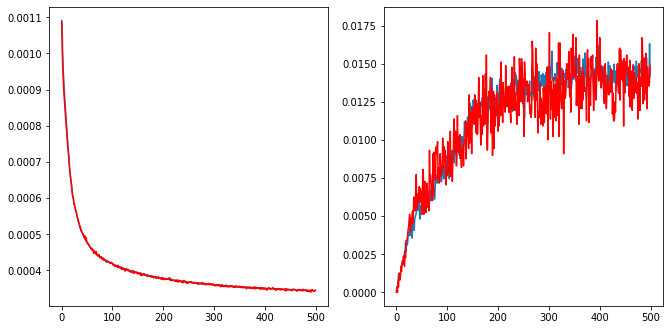

In [55]:
f1=plt.figure(figsize=[11,5.5])
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],color='r')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'],color='r')

In [26]:
predictions=model.predict(test_x)

In [15]:
model.save('45000s_500ep_0.0005lr_0.01delta.h5')

In [14]:
N=68
recon_ff=np.zeros((100,100))
recon_nf=np.zeros((100,100))
recon_pr=np.zeros((100,100))
Dat_ff=test_x[N,:]
Dat_nf=test_z[N,:]
Dat_pr=predictions[N,:]
for ii in range(100):
    a=Dat_nf[ii*100:(ii+1)*100]
    b=Dat_ff[ii*100:(ii+1)*100]
    c=Dat_pr[ii*100:(ii+1)*100]
    
    recon_nf[ii,:]=a
    recon_ff[ii,:]=b
    recon_pr[ii,:]=c
   # if (ii%2)==0:
    #    recon_nf[ii,:]=a
     #   recon_ff[ii,:]=b
      #  recon_pr[ii,:]=c
   # else:
    #    recon_nf[ii,:]=np.flip(a)
     #   recon_ff[ii,:]=np.flip(b)
      #  recon_pr[ii,:]=np.flip(c)


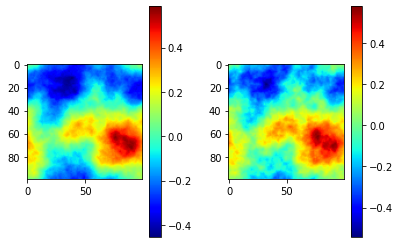

In [15]:

plt.subplot(1,2,1)
plt.imshow(recon_pr,cmap = 'jet')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(recon_nf,cmap = 'jet')
plt.colorbar()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

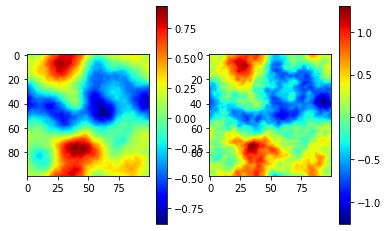

In [50]:
plt.subplot(1,2,1)
plt.imshow(recon_pr,cmap = 'jet')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(recon_nf,cmap = 'jet')
plt.colorbar()



In [40]:
#ii=0
#print(np.shape(predictions[ii,:]))
corr_r=np.zeros(500)
sum_t=np.zeros(500)
sum_p=np.zeros(500)
from scipy.stats import pearsonr
for ii in range(500):
    sum_t[ii]=sum(abs(test_z[ii,:]))
    sum_p[ii]=sum(abs(predictions[ii,:])) 
    corr_r[ii]= pearsonr(abs(predictions[ii,:]),abs(test_z[ii,:]))[0]


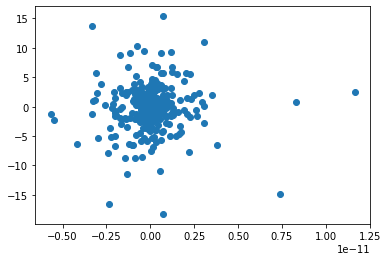

In [41]:
plt.plot(sum_t,sum_p,marker='o',linewidth=0)


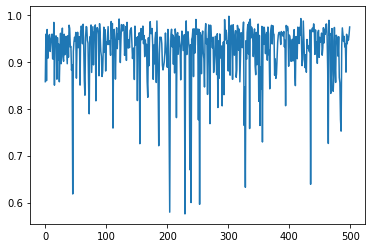

In [44]:
a =np.arange(0,500,1)
plt.plot(a,corr_r)

In [53]:
import statistics
print(statistics.mean(corr_r))
print(max(corr_r))

0.9245561467675211
0.9972583903774566


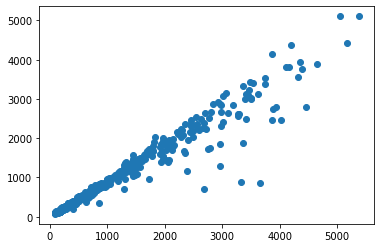

In [10]:
#ii=0
#print(np.shape(predictions[ii,:]))
corr_r=np.zeros(500)
sum_t=np.zeros(500)
sum_p=np.zeros(500)
from scipy.stats import pearsonr
for ii in range(500):
    sum_t[ii]=sum(abs(test_z[ii,:]))
    sum_p[ii]=sum(abs(predictions[ii,:])) 
    #corr_r[ii]= pearsonr(abs(predictions[ii,:]),abs(test_z[ii,:]))[0]
plt.plot(sum_t,sum_p,marker='o',linewidth=0)

In [11]:
slope = np.polyfit(sum_t,sum_p,1)
print(slope)

[ 0.84194519 23.87525709]
